<a href="https://colab.research.google.com/github/Mr-Slippery/aifractals/blob/main/load_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [224]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [225]:
N = 128

[<PIL.Image.Image image mode=L size=128x128 at 0x7F0BEBF85A50>, <PIL.Image.Image image mode=L size=128x128 at 0x7F0BEBF859D0>, <PIL.Image.Image image mode=L size=128x128 at 0x7F0BEBF852D0>, <PIL.Image.Image image mode=L size=128x128 at 0x7F0BEBF85F90>, <PIL.Image.Image image mode=L size=128x128 at 0x7F0BF2EC9550>, <PIL.Image.Image image mode=L size=128x128 at 0x7F0BEC209090>, <PIL.Image.Image image mode=L size=128x128 at 0x7F0BEC21DF10>, <PIL.Image.Image image mode=L size=128x128 at 0x7F0BEC21D6D0>, <PIL.Image.Image image mode=L size=128x128 at 0x7F0BEC21D910>, <PIL.Image.Image image mode=L size=128x128 at 0x7F0BF0E16750>, <PIL.Image.Image image mode=L size=128x128 at 0x7F0BEFE14710>]


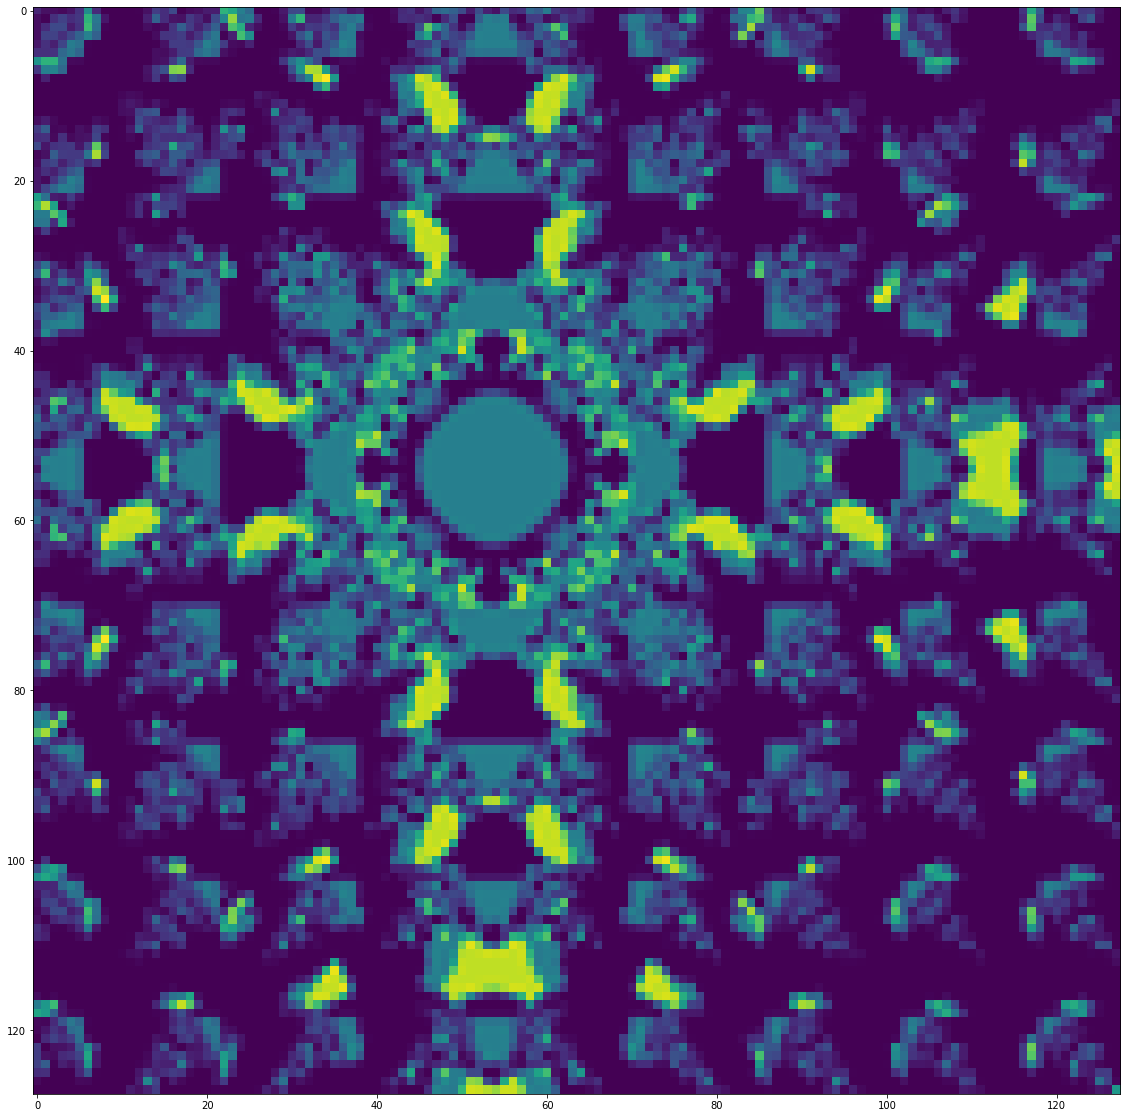

In [226]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np
import glob

%matplotlib inline 

input_folder = '/content/gdrive/MyDrive/Colab Notebooks/images/mandel'

image_list = [ImageOps.grayscale(ImageOps.fit(Image.open(name), (N, N))) for name in glob.glob(input_folder + '/*.png')]

def show(img, figsize=(20, 20), title=None):
  plt.figure(figsize=figsize)
  plt.imshow(img)
  if title:
    plt.title(title)
  plt.show()

print(image_list)

show(image_list[-1])

In [227]:
binary_samples = np.array([sample.getdata() for sample in image_list])

In [228]:
print(binary_samples[0])
print(len(binary_samples))

[43 10  2 ...  6  3 55]
11


In [229]:
new_samples = binary_samples.reshape(len(image_list), N, N)

In [230]:
print(new_samples)

[[[ 43  10   2 ...   8   0   0]
  [ 10   0  13 ...   3   0   0]
  [  2  11  39 ...   0   0   0]
  ...
  [ 23   9   0 ...  22  20   0]
  [  1   0   0 ...  54  30   1]
  [  0   0   0 ...   6   3  55]]

 [[  8   1   0 ...   0   5   6]
  [  2  11   3 ...   7   9   0]
  [  0   4  17 ...  14   1   0]
  ...
  [  0   6  12 ...  12   3   0]
  [  5   9   1 ...   3   8   2]
  [  7   0   0 ...   0   2   6]]

 [[ 66  23  68 ...  34  13   2]
  [ 25  58  81 ... 113  33   0]
  [ 63  81  85 ...  29  18   0]
  ...
  [ 59 116  15 ...  63  95  23]
  [ 24  79  21 ...  84  58  20]
  [  6   3   3 ...  39  41  37]]

 ...

 [[ 97  89 104 ... 165 124 116]
  [132 123 127 ... 172 152 145]
  [105  98 106 ... 164 135 133]
  ...
  [ 78  73  87 ... 149 102 107]
  [111 104 122 ... 169 137 139]
  [132 126 132 ... 175 151 150]]

 [[168 168 168 ... 168 168 168]
  [168 168 168 ... 168 168 168]
  [168 168 168 ... 168 168 168]
  ...
  [168 168 168 ... 168 168 168]
  [168 168 168 ... 168 168 168]
  [168 168 168 ... 168 168 1

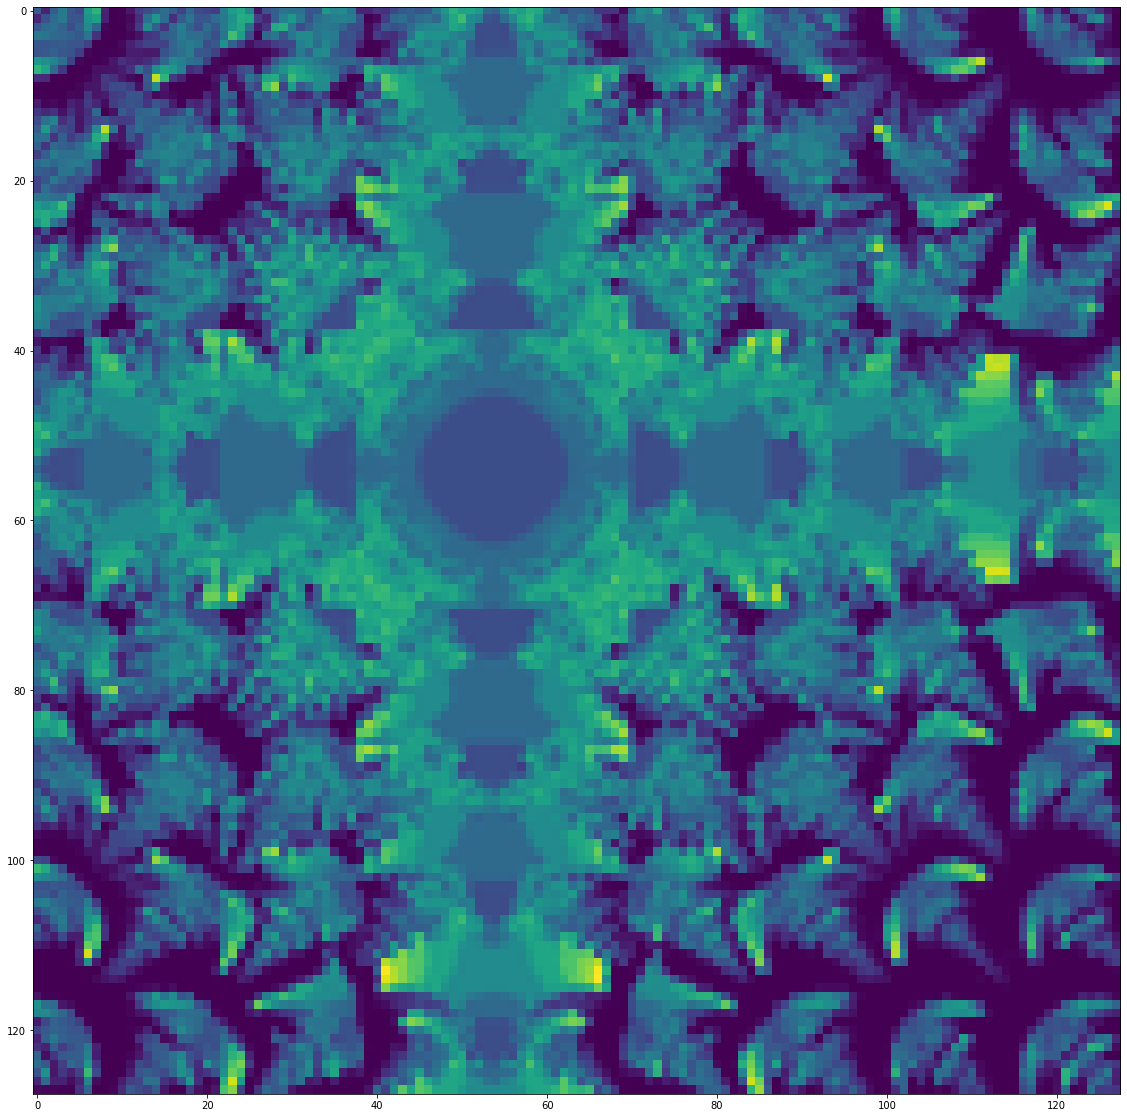

In [231]:
show(new_samples[2])

In [232]:
classes = np.array([0 for _ in range(11)]).reshape(-1)
print(classes)

[0 0 0 0 0 0 0 0 0 0 0]


In [233]:
xfile = 'fractals_x_test.npy'
yfile = 'fractals_y_test.npy'
np.save(xfile, new_samples)
np.save(yfile, classes)

In [234]:
x_test = np.load(xfile)
y_test = np.load(yfile)
x_test.shape, y_test.shape

((11, 128, 128), (11,))

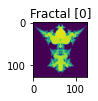

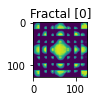

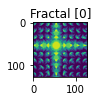

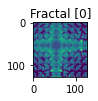

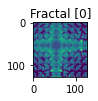

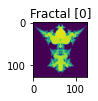

In [235]:
for i in np.random.randint(x_test.shape[0], size=6):
    show(x_test[i], title=f'Fractal [{y_test[i]}]', figsize=(1,1))

In [236]:
import tensorflow as tf

In [237]:
tf.__version__

'2.6.0'

In [238]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-vm_iklaj
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-vm_iklaj


In [239]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [240]:
train_images = x_test

In [241]:
train_labels = y_test

In [242]:
train_images = train_images.reshape(train_images.shape[0], N, N, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [243]:
BUFFER_SIZE = 11
BATCH_SIZE = 4

In [244]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [245]:
print(train_dataset)

<BatchDataset shapes: (None, 128, 128, 1), types: tf.float32>


In [246]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(32*32*256, use_bias=False, input_shape=(128,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((32, 32, 256)))
    assert model.output_shape == (None, 32, 32, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 1)

    return model

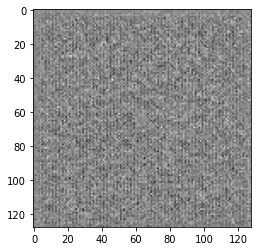

In [247]:
generator = make_generator_model()

noise = tf.random.normal([1, 128])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [248]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[128, 128, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [249]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[5.413759e-05]], shape=(1, 1), dtype=float32)


In [250]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [251]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [252]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [253]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [254]:
checkpoint_dir = '/mount/gdrive/MyDrive/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [255]:
EPOCHS = 100
noise_dim = 128
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [256]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [257]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [258]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

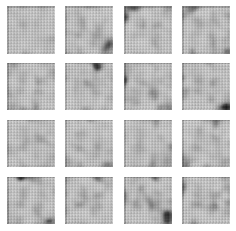

In [259]:
train(train_dataset, EPOCHS)

In [260]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [261]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [262]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


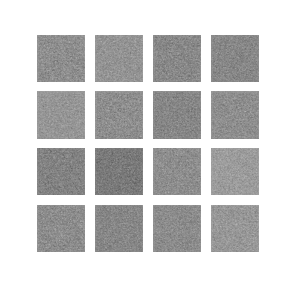

In [263]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)